In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import h5py
import json
import os

folder = 'LOSC_Event_tutorial/'
plt.style.use('seaborn-muted')

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [6]:
strain_H1, dt_H1, utc_H1 = read_file(folder+'H-H1_LOSC_4_V2-1126259446-32.hdf5')
strain_L1, dt_L1, utc_L1 = read_file(folder + 'L-L1_LOSC_4_V2-1126259446-32.hdf5')
template_name='GW150914_4_template.hdf5'
th,tl=read_template(folder + template_name)

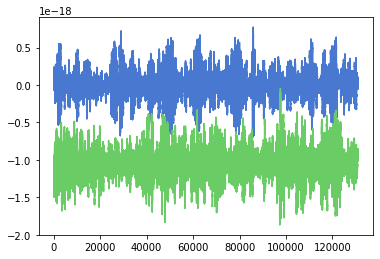

In [7]:
plt.plot(strain_H1)
plt.plot(strain_L1)
plt.show()

In [16]:
# Define window functions 
def window(n):
    x = np.linspace(-np.pi, np.pi, n)
    return 0.5 + 0.5*np.cos(x)

def make_flat_window(n,m):
    tmp = window(m)
    win = np.ones(n)
    mm = m//2
    win[:mm] = tmp[:mm]
    win[-mm:] = tmp[-mm: ]
    return win

In [43]:
# Whiten the strain
n = len(strain_H1)
win = make_flat_window(n, n//5)
sft = np.fft.rfft(win*strain_H1)

Nft=np.abs(sft)**2
for i in range(10):
    Nft=(Nft+np.roll(Nft,1)+np.roll(Nft,-1))/3
sft_white=sft/np.sqrt(Nft)
tft_white=np.fft.rfft(th*win)/np.sqrt(Nft)
t_white=np.fft.irfft(tft_white)

xcorr2_H=np.fft.irfft(sft_white*np.conj(tft_white))

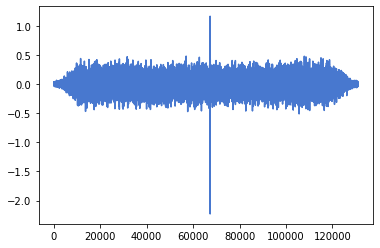

In [44]:
plt.plot(np.roll(xcorr2_H, len(xcorr2_H)//2))

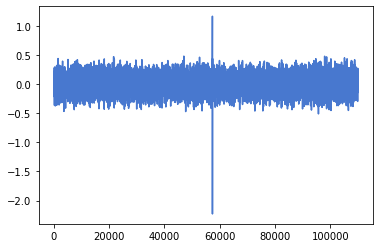

In [47]:
data = np.roll(xcorr2_H,  len(xcorr2_H)//2)
data_wo_win_H = data[10000:120000]
plt.plot(data_wo_win_H)

In [49]:
std_H = np.std(data_wo_win_H)

In [50]:
np.abs(np.min(data_wo_win_H)/std_H)

16.933476426111476

In [40]:
# Whiten the strain
n = len(strain_L1)
win = make_flat_window(n, n//5)
sft = np.fft.rfft(win*strain_L1)

Nft=np.abs(sft)**2
for i in range(10):
    Nft=(Nft+np.roll(Nft,1)+np.roll(Nft,-1))/3
sft_white=sft/np.sqrt(Nft)
tft_white=np.fft.rfft(tl*win)/np.sqrt(Nft)
t_white=np.fft.irfft(tft_white)

xcorr2_L=np.fft.irfft(sft_white*np.conj(tft_white))

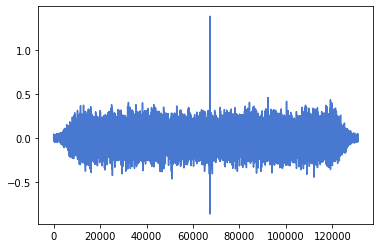

In [51]:
plt.plot(np.roll(xcorr2_L, len(xcorr2_L)//2))

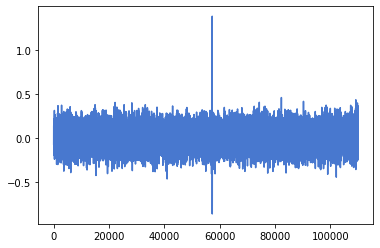

In [52]:
data = np.roll(xcorr2_L,  len(xcorr2_L)//2)
data_wo_win_L = data[10000:120000]
plt.plot(data_wo_win_L)

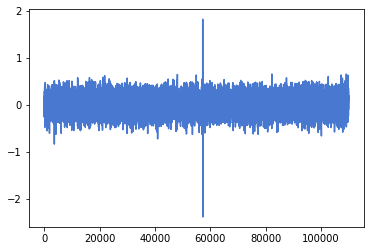

In [53]:
plt.plot(data_wo_win_L + data_wo_win_H)